In [9]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy
from tqdm import tqdm
import mne

In [10]:
df = pd.read_csv('../Datasets/input.csv')
missing = df.isna().sum()
sep_col = missing[missing == df.shape[0]].index[0]

In [11]:
ptsd = df[df['specific.disorder'] == 'Posttraumatic stress disorder']
hc = df[df['specific.disorder'] == 'Healthy control'].sample(n=52, random_state=42)
data = pd.concat([ptsd, hc])
X = data

X = X.drop([sep_col, 'no.', 'eeg.date','main.disorder'], axis=1)

target_col = ['specific.disorder']
cat_col = ['sex']
sex_ord = df['sex'].unique()

# encoder for targets and sex
enc = OrdinalEncoder(categories=[sex_ord])
X[cat_col] = enc.fit_transform(X[cat_col])
X['specific.disorder'] = X['specific.disorder'].map({'Posttraumatic stress disorder': 1, 'Healthy control': 0})
target = X['specific.disorder']
X.drop(target_col, axis=1, inplace=True)


imputer=SimpleImputer()
# fill missing data
mv_cols = ['education', 'IQ']
X[mv_cols] = imputer.fit_transform(X[mv_cols])

# numerical columns for log-transformation
logtrans_cols = X.drop(['sex', 'education', 'IQ'], axis=1).columns
X[logtrans_cols] = X[logtrans_cols].apply(pd.to_numeric, errors='coerce')

In [12]:
def cache_mkdir(cache, directory, root_dir='.'):
    """Create directory and return path to it"""
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def read_cache(cache, path, silent=False)m:
    """Read from cache file"""
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def write_cache(cache, obj, path):
    """Write to cache"""
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file) 

In [13]:
# Function to extract a specific row based on disorder and algorithm
def get_row(result, disorder, algorithm):
    return result[(result['disorder'] == disorder) & (result['algorithm'] == algorithm)].squeeze()

# Function to initialize and set parameters for a model
def get_model(row, models):
    model = deepcopy(models[row['algorithm']])
    model.set_params(**row['params'])
    return model

# Function to perform Cross-Validation and extract feature importances
def cv_fi(x, y, model, random_state=None, n=10, debug=True):
    feature_names = x.columns
    cv_results = dict()
    i = 1  # Split counter

    # KFold splitting
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=random_state)
    
    for train_index, test_index in skf.split(x, y):
        # Get train x and y
        x_train, y_train = x.iloc[train_index], y.iloc[train_index]
        # Scale features
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        # Fit model
        model.fit(x_train, y_train)
        # Save feature importance
        cv_results[f'split{i}_fi'] = model.feature_importances_

        # Debug information
        if debug:
            x_test, y_test = x.iloc[test_index], y.iloc[test_index]
            x_test = scaler.transform(x_test)
            y_pred = model.predict(x_test)
            print(f'Split {i} report')
            print(classification_report(y_test, y_pred))
        
        i += 1
    result = pd.DataFrame(cv_results, index=feature_names)
    return result

# Function to classify features as PSD or FC based on naming convention
def psd_coh(name):
    splt = name.split(sep='.')
    if len(splt) < 5:
        result = name
    elif len(splt) == 5:
        result = f'{splt[2]} PSD'
    else:
        result = f'{splt[2]} FC'
    return result

# Function to create a summary feature importance table
def summary_fi_table(table, threshold=0):
    table.index.name = 'feature'
    table = table.reset_index().melt(id_vars='feature', var_name='split_id', value_name='importance')
    n_imp = (table['importance'] < 0).any()

    # Mark survived features based on threshold
    table['survived'] = (table['importance'].abs() > threshold)
    table['feature_cat'] = table['feature'].apply(psd_coh)

    # Summary table with aggregations
    result = table.groupby(['feature_cat', 'feature']).agg({
        'importance': ['sum', 'mean', 'median'],
        'survived': 'mean'
    })
    return result

# Function to flatten multi-level column indices
def flatten_columns(table):
    """Flatten column indices"""
    table.columns = ['_'.join(col) for col in table.columns.values]
    return table

# Function to extract top N important features
def top_n(table, n=15, col='importance_sum', survival_thres=0.7, abs_based=True):
    """Report n top important features"""
    if abs_based:
        table['abs_col'] = table[col].abs()
        col = 'abs_col'
    result = table[table['survived_mean'] >= survival_thres].sort_values(col, ascending=False).iloc[:n]
    return result


In [14]:
CatBoost=CatBoostClassifier(random_seed=77, logging_level='Silent')
cache=True
cache_dir='cv_fi'
exclude=['sex', 'age', 'education', 'IQ']

X = pd.DataFrame(X) 
Y = pd.Series(target)

cache_mkdir(cache, cache_dir)
cache_file = os.path.join(cache_dir, 'result')

fi = read_cache(cache, cache_file)
if fi is None:
    fi = cv_fi(X,Y,CatBoost)
    write_cache(cache, fi, cache_file)
fi = fi[~fi.index.isin(exclude)]
result=fi

result

Split 1 report
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.75      1.00      0.86         6

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11

Split 2 report
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.83      0.83      0.83         6

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11

Split 3 report
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.80      0.89         5

    accuracy                           0.91        11
   macro avg       0.93      0.90      0.91        11
weighted avg       0.92      

,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi
AB.A.delta.a.FP1,0.026045,0.062652,0.031398,0.006075,0.029874,0.026628,0.027192,0.005395,0.066984,0.074200
AB.A.delta.b.FP2,0.058240,0.066588,0.062715,0.039727,0.011339,0.070736,0.012200,0.044895,0.088104,0.118946
AB.A.delta.c.F7,0.056539,0.107534,0.140418,0.105608,0.058059,0.033478,0.101960,0.091185,0.061320,0.155380
AB.A.delta.d.F3,0.055134,0.088193,0.191402,0.072720,0.114094,0.242472,0.147527,0.110395,0.065406,0.200869
AB.A.delta.e.Fz,0.036797,0.048417,0.046987,0.106646,0.128454,0.203695,0.070081,0.034999,0.023065,0.008721
...,...,...,...,...,...,...,...,...,...,...
COH.F.gamma.p.P4.r.O1,0.050840,0.047964,0.053482,0.038983,0.026775,0.046557,0.023658,0.035467,0.128094,0.034945
COH.F.gamma.p.P4.s.O2,0.042057,0.031744,0.025959,0.031371,0.040656,0.092241,0.029712,0.055449,0.055862,0.038360
COH.F.gamma.q.T6.r.O1,0.080621,0.011375,0.050383,0.045986,0.052152,0.048234,0.061436,0.114525,0.040398,0.033376
COH.F.gamma.q.T6.s.O2,0.045076,0.015677,0.057266,0.020913,0.032045,0.024205,0.016409,0.030317,0.015294,0.015023


In [15]:
df=pd.DataFrame(result)
df['mean_fi'] = df.mean(axis=1)
importances = df.sort_values(by='mean_fi', ascending=False)

In [16]:
# Initializing a dictionary to store sums for each band-category combination across all splits
psd_fc_split_sums = {
    'Delta PSD': [0] * 10,
    'Theta PSD': [0] * 10,
    'Alpha PSD': [0] * 10,
    'Beta PSD': [0] * 10,
    'Gamma PSD': [0] * 10,
    'Highbeta PSD': [0] * 10,
    'Delta FC': [0] * 10,
    'Theta FC': [0] * 10,
    'Alpha FC': [0] * 10,
    'Beta FC': [0] * 10,
    'Gamma FC': [0] * 10,
    'Highbeta FC': [0] * 10
}

# Iterate over each feature and sum values accordingly for each split
for feature in importances.index:
    split_values = importances.loc[feature, importances.columns[:-1]].values  # Get values for each split (ignoring mean)
    if feature.startswith('AB'):
        if 'delta' in feature:
            psd_fc_split_sums['Delta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Delta PSD'], split_values)]
        elif 'theta' in feature:
            psd_fc_split_sums['Theta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Theta PSD'], split_values)]
        elif 'alpha' in feature:
            psd_fc_split_sums['Alpha PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Alpha PSD'], split_values)]
        elif 'beta' in feature:
            psd_fc_split_sums['Beta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Beta PSD'], split_values)]
        elif 'gamma' in feature:
            psd_fc_split_sums['Gamma PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Gamma PSD'], split_values)]
        elif 'highbeta' in feature:
            psd_fc_split_sums['Highbeta PSD'] = [x + y for x, y in zip(psd_fc_split_sums['Highbeta PSD'], split_values)]
    elif feature.startswith('COH'):
        if 'delta' in feature:
            psd_fc_split_sums['Delta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Delta FC'], split_values)]
        elif 'theta' in feature:
            psd_fc_split_sums['Theta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Theta FC'], split_values)]
        elif 'alpha' in feature:
            psd_fc_split_sums['Alpha FC'] = [x + y for x, y in zip(psd_fc_split_sums['Alpha FC'], split_values)]
        elif 'beta' in feature:
            psd_fc_split_sums['Beta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Beta FC'], split_values)]
        elif 'gamma' in feature:
            psd_fc_split_sums['Gamma FC'] = [x + y for x, y in zip(psd_fc_split_sums['Gamma FC'], split_values)]
        elif 'highbeta' in feature:
            psd_fc_split_sums['Highbeta FC'] = [x + y for x, y in zip(psd_fc_split_sums['Highbeta FC'], split_values)]

# Creating a DataFrame from the dictionary
psd_fc = pd.DataFrame.from_dict(psd_fc_split_sums, orient='index', columns=importances.columns[:-1])
psd_fc['mean']=psd_fc.mean(axis=1)
psd_fc

,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi,mean
Delta PSD,1.682481,1.808449,1.426136,1.567790,1.793308,1.652409,1.477355,1.266651,1.274362,1.592730,1.554167
Theta PSD,1.820199,2.111103,2.406674,1.608533,2.752882,1.032258,2.043740,2.168576,1.388397,1.710482,1.904284
Alpha PSD,1.237786,0.871789,1.116687,1.021502,1.082149,0.907734,1.019242,1.138502,0.983180,1.107887,1.048646
Beta PSD,12.243496,5.086408,5.602148,6.446284,6.038390,8.252729,5.076762,5.083722,3.916865,5.588640,6.333544
Gamma PSD,0.866596,0.724709,1.119013,0.623455,1.115948,0.732053,0.974689,0.975878,0.999166,0.994348,0.912585
Highbeta PSD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Delta FC,13.287222,12.949545,13.629464,15.601853,13.255844,11.473403,13.774715,12.059128,13.051652,14.833902,13.391673
Theta FC,8.633494,9.331002,8.950914,9.095365,9.253218,7.884367,8.714460,9.221042,9.223196,10.104726,9.041178
Alpha FC,11.355275,11.172987,12.467304,9.258727,11.137992,13.994994,11.319351,11.174332,13.568165,14.465928,11.991506
Beta FC,14.212497,15.043822,17.425349,14.242375,17.300091,16.419936,16.777022,16.739627,16.088783,15.121795,15.937130


In [17]:
psd_fc_fi=psd_fc.sort_values(by='mean', ascending=False)
psd_fc_fi=psd_fc_fi.head(10)
psd_fc_fi

,split1_fi,split2_fi,split3_fi,split4_fi,split5_fi,split6_fi,split7_fi,split8_fi,split9_fi,split10_fi,mean
Beta FC,14.212497,15.043822,17.425349,14.242375,17.300091,16.419936,16.777022,16.739627,16.088783,15.121795,15.937130
Delta FC,13.287222,12.949545,13.629464,15.601853,13.255844,11.473403,13.774715,12.059128,13.051652,14.833902,13.391673
Alpha FC,11.355275,11.172987,12.467304,9.258727,11.137992,13.994994,11.319351,11.174332,13.568165,14.465928,11.991506
Theta FC,8.633494,9.331002,8.950914,9.095365,9.253218,7.884367,8.714460,9.221042,9.223196,10.104726,9.041178
Beta PSD,12.243496,5.086408,5.602148,6.446284,6.038390,8.252729,5.076762,5.083722,3.916865,5.588640,6.333544
Gamma FC,6.752058,6.298189,6.531225,5.480178,6.119102,6.393190,6.150714,6.741624,6.578087,5.983430,6.302780
Theta PSD,1.820199,2.111103,2.406674,1.608533,2.752882,1.032258,2.043740,2.168576,1.388397,1.710482,1.904284
Delta PSD,1.682481,1.808449,1.426136,1.567790,1.793308,1.652409,1.477355,1.266651,1.274362,1.592730,1.554167
Alpha PSD,1.237786,0.871789,1.116687,1.021502,1.082149,0.907734,1.019242,1.138502,0.983180,1.107887,1.048646
Gamma PSD,0.866596,0.724709,1.119013,0.623455,1.115948,0.732053,0.974689,0.975878,0.999166,0.994348,0.912585


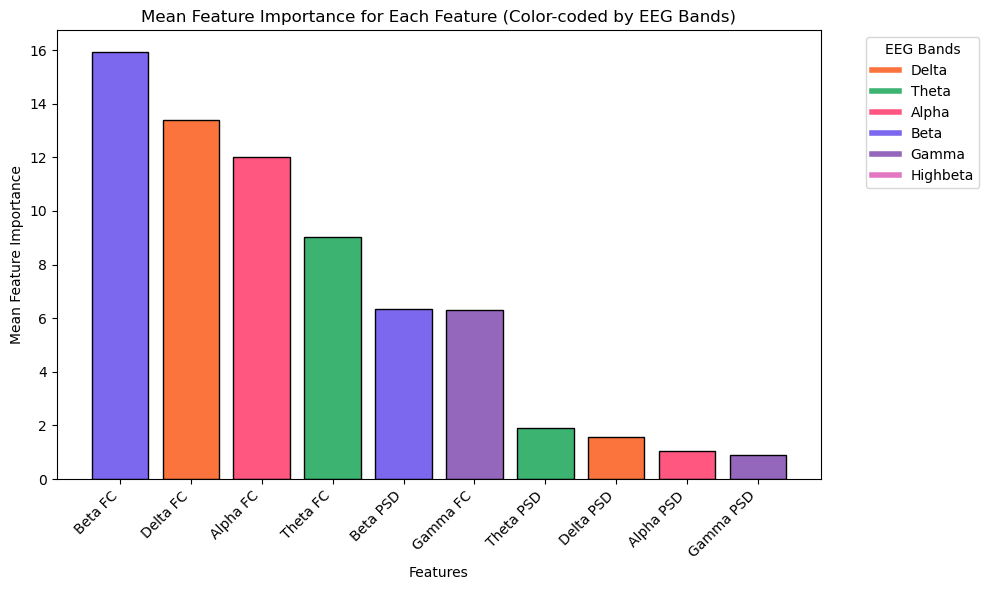

In [18]:
# Assigning colors based on EEG bands
band_colors = {
    'Delta': '#FB743E',    # vibrant blue
    'Theta': '#3cb371',    # vibrant green
    'Alpha': '#FF577F',    # vibrant orange
    'Beta': '#7b68ee',     # vibrant red
    'Gamma': '#9467bd',    # vibrant purple
    'Highbeta': '#e377c2'}

# Determining band for each feature and assigning color
colors = []
for feature in psd_fc_fi.index:
    found = False
    for band, color in band_colors.items():
        if band in feature:
            colors.append(color)
            found = True
            break
    if not found:
        colors.append('grey')


# Plotting the mean values with color coding based on EEG bands
plt.figure(figsize=(10, 6))
plt.bar(psd_fc_fi.index, psd_fc_fi['mean'], color=colors, edgecolor='black')
plt.xlabel('Features')
plt.ylabel('Mean Feature Importance')
plt.title('Mean Feature Importance for Each Feature (Color-coded by EEG Bands)')
plt.xticks(rotation=45, ha='right')


# Adding a legend for all EEG bands, even if not present in the data
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in band_colors.values()]
legend_titles = list(band_colors.keys())
plt.legend(legend_labels, legend_titles, title='EEG Bands', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
fi=importances.head(10)
print(fi)

                        split1_fi  split2_fi  split3_fi  split4_fi  split5_fi  \
AB.D.beta.m.T5           4.332378   1.259409   1.227083   1.737417   1.909946   
COH.A.delta.e.Fz.f.F4    0.958471   0.703756   1.074857   0.478878   1.855782   
COH.A.delta.c.F7.f.F4    0.560451   0.278103   0.854507   0.779367   0.508070   
AB.D.beta.q.T6           1.580134   0.437312   0.588041   0.447438   0.792598   
COH.C.alpha.a.FP1.n.P3   0.258558   0.335839   0.692813   0.111752   0.837091   
COH.A.delta.o.Pz.r.O1    0.701172   0.442676   0.416981   0.572013   0.388951   
COH.C.alpha.b.FP2.e.Fz   0.547347   0.312533   0.275464   0.216955   0.297383   
COH.B.theta.e.Fz.f.F4    0.528223   0.558750   0.388710   0.122842   0.683573   
COH.A.delta.i.C3.m.T5    0.259910   0.133626   0.249482   1.132002   0.369725   
AB.D.beta.c.F7           0.525562   0.211625   0.397776   0.443374   0.279729   

                        split6_fi  split7_fi  split8_fi  split9_fi  \
AB.D.beta.m.T5           3.505504   1.

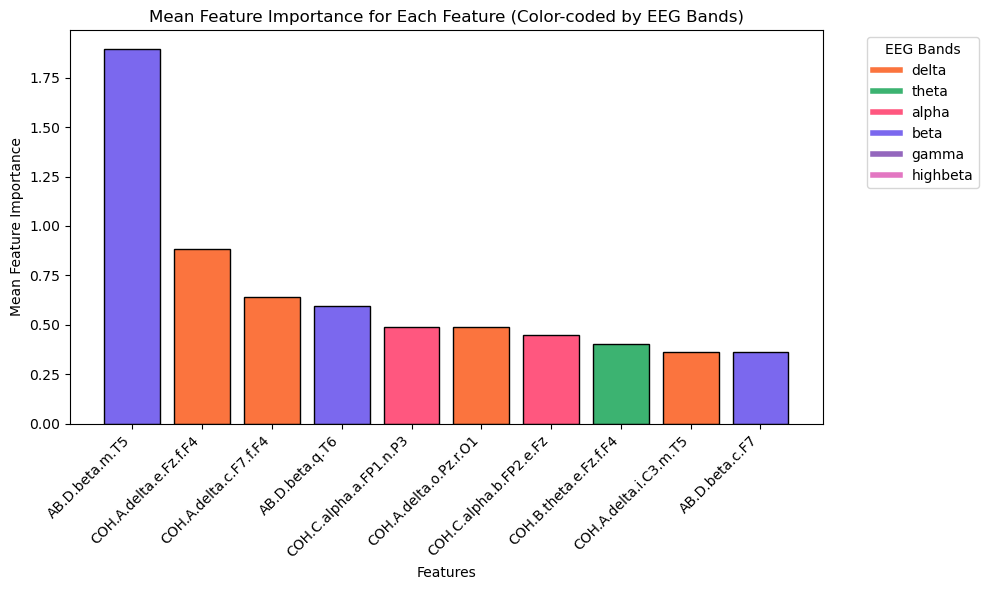

In [20]:

# Assigning colors based on EEG bands
band_colors = {
    'delta': '#FB743E',    # vibrant blue
    'theta': '#3cb371',    # vibrant green
    'alpha': '#FF577F',    # vibrant orange
    'beta': '#7b68ee',     # vibrant red
    'gamma': '#9467bd',    # vibrant purple
    'highbeta': '#e377c2'}

# Determining band for each feature and assigning color
colors = []
for feature in fi.index:
    found = False
    for band, color in band_colors.items():
        if band in feature:
            colors.append(color)
            found = True
            break
    if not found:
        colors.append('grey')


# Plotting the mean values with color coding based on EEG bands
plt.figure(figsize=(10, 6))
plt.bar(fi.index, fi['mean_fi'], color=colors, edgecolor='black')
plt.xlabel('Features')
plt.ylabel('Mean Feature Importance')
plt.title('Mean Feature Importance for Each Feature (Color-coded by EEG Bands)')
plt.xticks(rotation=45, ha='right')


# Adding a legend for all EEG bands, even if not present in the data
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in band_colors.values()]
legend_titles = list(band_colors.keys())
plt.legend(legend_labels, legend_titles, title='EEG Bands', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
